In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt

from ccn import Constraint, ConstraintsGroup
from shapes import Rectangle
from experiment import Experiment

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Define the shapes

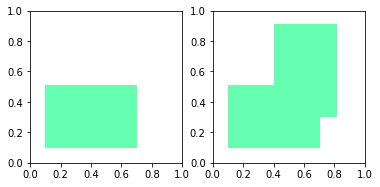

In [2]:
rect0 = Rectangle(0.1, 0.7, 0.1, 0.5)
rect1 = Rectangle(0.4, 0.8, 0.3, 0.9)
combined = rect0 | rect1
shapes = [rect0, combined]

fig, ax = plt.subplots(1, len(shapes))
for i, shape in enumerate(shapes):
  shape.plot(ax[i], full=True)
plt.show()

constraints1 = [ConstraintsGroup([Constraint('1 :- 0')])]
constraints2 = [ConstraintsGroup([Constraint('n0 :- n1')])]

### Define the neural network

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(2, 4),
            nn.Tanh(),
            nn.Linear(4, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.linear(x)
        return x

model1 = NeuralNetwork()
model2 = NeuralNetwork()
print(model1)

NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=2, bias=True)
    (3): Sigmoid()
  )
)


### Train and test the model

Epoch 1
-------------------------------
loss: 0.689247 [    0/10000]
loss: 0.563382 [ 6400/10000]
Test Error: 
 Accuracy: 76.7%, 54.5%
 Avg loss: 0.009230 

Epoch 2
-------------------------------
loss: 0.578454 [    0/10000]
loss: 0.560918 [ 6400/10000]
Test Error: 
 Accuracy: 71.9%, 57.9%
 Avg loss: 0.009032 

Epoch 3
-------------------------------
loss: 0.551436 [    0/10000]
loss: 0.562700 [ 6400/10000]
Test Error: 
 Accuracy: 72.2%, 57.7%
 Avg loss: 0.008973 

Epoch 4
-------------------------------
loss: 0.546361 [    0/10000]
loss: 0.560334 [ 6400/10000]
Test Error: 
 Accuracy: 71.9%, 58.2%
 Avg loss: 0.008907 

Epoch 5
-------------------------------
loss: 0.542507 [    0/10000]
loss: 0.557095 [ 6400/10000]
Test Error: 
 Accuracy: 72.4%, 57.6%
 Avg loss: 0.008813 

Epoch 6
-------------------------------
loss: 0.537940 [    0/10000]
loss: 0.552220 [ 6400/10000]
Test Error: 
 Accuracy: 73.3%, 58.3%
 Avg loss: 0.008657 

Epoch 7
-------------------------------
loss: 0.530984 [  

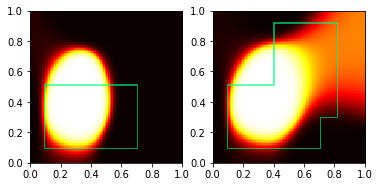

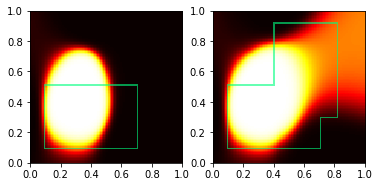

In [4]:
experiment = Experiment('rectangles-direct', model1, shapes, constraints1)
experiment.run(100)

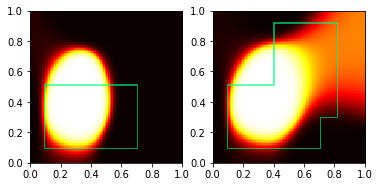

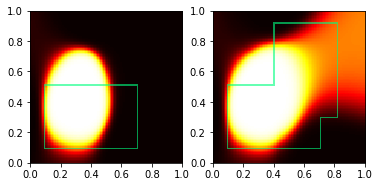

In [5]:
experiment.save(dir='./models/')